(100, 784)


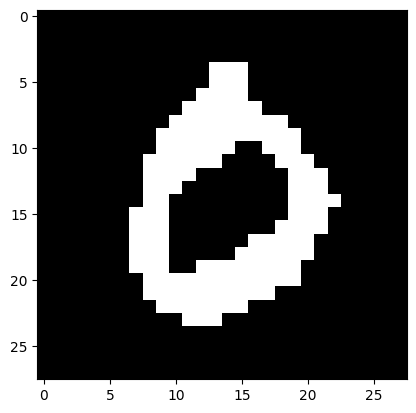

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from segmentacion.otsu import thresholdOtsu

def loadDataset(fileName, samples):
    x = []
    y = []
    train_data = pd.read_csv(fileName)
    y = np.array(train_data.iloc[0:samples, 0])
    x = np.array(train_data.iloc[0:samples, 1:])
    return x,y
 
x,y=loadDataset("Nmist/mnist_test.csv",100)

print(x.shape)
digit = x[2]
digit_pixels = digit.reshape(28, 28)
digit_pixels = thresholdOtsu(digit_pixels)
digit_pixels = digit_pixels.astype(np.uint8)
plt.imshow(digit_pixels, cmap='gray')
plt.show()

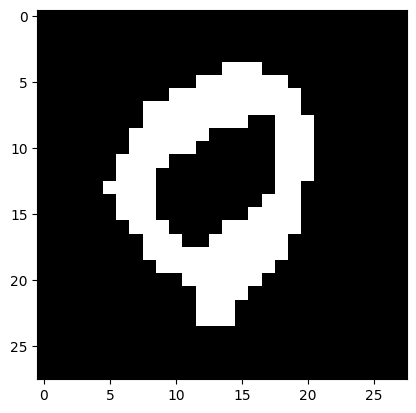

In [231]:
rotated_image_np = np.rot90(digit_pixels, k=180 // 90)
plt.imshow(rotated_image_np, cmap='gray')

In [232]:
contours, hierarchy = cv2.findContours(digit_pixels, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0].shape)

(34, 1, 2)


In [233]:
contours, hierarchy = cv2.findContours(rotated_image_np, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0].shape)

(34, 1, 2)


In [234]:
def fft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N <= 32:  # Este es un límite arbitrario para la recursión
        return np.dot(np.vander(np.exp(-2j * np.pi * np.arange(N) / N), N), x)
    else:
        X_even = fft(x[::2])
        X_odd = fft(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd, X_even + factor[N // 2:] * X_odd])

In [235]:
def fft(x):
    N = len(x)
    if N <= 1:
        return x
    even = fft(x[::2])
    odd = fft(x[1::2])
    T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [even[k] + T[k] for k in range(N // 2)] + [even[k] - T[k] for k in range(N // 2)]

# Ejemplo de uso con números complejos:
x = np.array([1+2j, 2+3j, 3+4j, 4+5j])
result = fft(x)
result2 = np.fft.fft(x)
print(result)
print(result2)

[(10+14j), (-4-2.220446049250313e-16j), (-2-2j), -4j]
[10.+14.j -4. +0.j -2. -2.j  0. -4.j]


In [236]:
def fft_custom(x):
    N = len(x)
    if N <= 1:
        return x
    even = fft_custom(x[::2])
    odd = fft_custom(x[1::2])
    combined = [0] * N
    for m in range(N // 2):
        combined[m] = even[m] + np.exp(-2j * np.pi * m / N) * odd[m]
        combined[m + N // 2] = even[m] - np.exp(-2j * np.pi * m / N) * odd[m]
    return combined

In [256]:
def find_fourier_descriptorsRotation(image):
    # Encuentra los contornos en la imagen
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Encuentra el contorno más largo
    max_contour = max(contours, key=len)

    # Calcula la transformada de Fourier de los contornos
    contour_complex = [complex(c[0][0], c[0][1]) for c in max_contour]
    fourier_transform = np.fft.fft(contour_complex)
    
    fourierCh = []
    for i in range(2, len(fourier_transform)):
        fourierCh = np.append(fourierCh, abs(fourier_transform[i]) / abs(fourier_transform[1]))

    return fourierCh

In [257]:
n = find_fourier_descriptorsRotation(digit_pixels)
r = find_fourier_descriptorsRotation(rotated_image_np)

In [258]:
print(n)

[0.61417492 0.34290528 0.21484551 0.16317755 0.13787254 0.12470374
 0.0700416  0.04922783 0.04133585 0.06932618 0.06317387 0.06868895
 0.02921761 0.00998151 0.06020184 0.03956355 0.01826162 0.02794877
 0.03707234 0.08236615 0.07523489 0.08498446 0.084987   0.04606373
 0.03052685 0.0694315  0.02875942 0.05795358 0.02537726 0.07916942
 0.01263132 0.03934491 0.03117759 0.04277934 0.04686496 0.0258477
 0.06666785 0.07178658 0.03518507 0.04346813 0.05353454 0.29585652
 0.16654614 0.16252599 8.08080439]


In [259]:
r = find_fourier_descriptorsRotation(rotated_image_np)

In [260]:
print(r)

[0.61417492 0.34290528 0.21484551 0.16317755 0.13787254 0.12470374
 0.0700416  0.04922783 0.04133585 0.06932618 0.06317387 0.06868895
 0.02921761 0.00998151 0.06020184 0.03956355 0.01826162 0.02794877
 0.03707234 0.08236615 0.07523489 0.08498446 0.084987   0.04606373
 0.03052685 0.0694315  0.02875942 0.05795358 0.02537726 0.07916942
 0.01263132 0.03934491 0.03117759 0.04277934 0.04686496 0.0258477
 0.06666785 0.07178658 0.03518507 0.04346813 0.05353454 0.29585652
 0.16654614 0.16252599 8.08080439]


In [242]:
print(n == r)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True]


In [243]:
tolerancia = 1e-9  # Define la tolerancia deseada

for i in range(len(n)):
    if abs(n[i] - r[i]) > tolerancia:
        print(f"Los elementos en la posición {i} no son iguales. n[{i}] = {n[i]}, r[{i}] = {r[i]}")


Los elementos en la posición 0 no son iguales. n[0] = 0.07938793151434041, r[0] = 0.09447953803140927
Los elementos en la posición 1 no son iguales. n[1] = 0.033876082025439264, r[1] = 0.12084664949150704
Los elementos en la posición 2 no son iguales. n[2] = 0.2754289071467391, r[2] = 0.34666083407791837
Los elementos en la posición 3 no son iguales. n[3] = 0.07748303627184552, r[3] = 0.08172207969517059
Los elementos en la posición 4 no son iguales. n[4] = 0.06291904064275446, r[4] = 0.04113569074415556
Los elementos en la posición 5 no son iguales. n[5] = 0.24128066279094756, r[5] = 0.25648611908256946
Los elementos en la posición 6 no son iguales. n[6] = 0.12240047929864606, r[6] = 0.15249412054342873
Los elementos en la posición 7 no son iguales. n[7] = 0.11176250519875727, r[7] = 0.11777694679062212
Los elementos en la posición 8 no son iguales. n[8] = 0.22500756556324578, r[8] = 0.30372481779485677
Los elementos en la posición 9 no son iguales. n[9] = 0.08241011084005305, r[9] = 

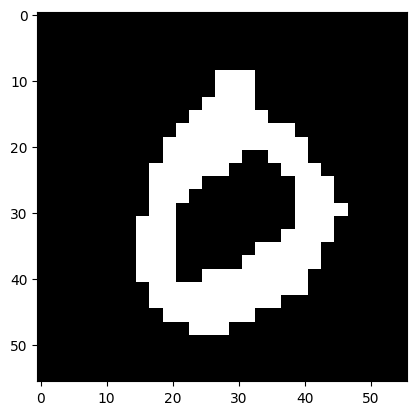

In [244]:
import numpy as np
import matplotlib.pyplot as plt

def escPeque(img):
        new_height = 56
        new_width = 56

        # Escalar la matriz binaria utilizando interpolación
        scaled_matrix = np.zeros((new_height, new_width))

        for i in range(new_height):
                for j in range(new_width):
                        xi = int((i / (new_height - 1)) * (img.shape[0] - 1))
                        yi = int((j / (new_width - 1)) * (img.shape[1] - 1))
                        x1, x2 = xi, min(xi + 1, img.shape[0] - 1)
                        y1, y2 = yi, min(yi + 1, img.shape[1] - 1)  # Corregido 'y' a 'yi'
                        dx, dy = xi - x1, yi - y1
                        value = (1 - dx) * (1 - dy) * img[x1, y1] + dx * (1 - dy) * img[x2, y1] + \
                                (1 - dx) * dy * img[x1, y2] + dx * dy * img[x2, y2]
                        
                        scaled_matrix[i, j] = value

        # Redondear los valores de la matriz escalada a 0 o 1
        scaled_matrix = np.round(scaled_matrix)
        scaled_matrix = scaled_matrix.astype(np.uint8)
        return scaled_matrix
plt.imshow(escPeque(digit_pixels), cmap='gray')


In [245]:

def find_fourier_descriptorsRotation2(image, desired_contour_length=100):
    # Encuentra los contornos en la imagen
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Encuentra el contorno más largo
    max_contour = max(contours, key=len)

    # Redimensionar el contorno a una longitud deseada para la normalización de escala
    max_contour = cv2.approxPolyDP(max_contour, 0.05 * cv2.arcLength(max_contour, True), True)
    contour_length = len(max_contour)
    scale_factor = desired_contour_length / contour_length
    max_contour = np.array(max_contour) * scale_factor

    # Calcula la transformada de Fourier de los contornos normalizados
    contour_complex = [complex(c[0][0], c[0][1]) for c in max_contour]
    fourier_transform = np.fft.fft(contour_complex)
    
    fourierCh = []
    for i in range(2, len(fourier_transform)):
        fourierCh = np.append(fourierCh, abs(fourier_transform[i])/abs(fourier_transform[1]))

    return fourierCh

In [246]:
esc = find_fourier_descriptorsRotation2(escPeque(digit_pixels))
print(esc)

[0.56309251 5.50166272]


In [247]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def escalar(img):
    # Supongamos que 'digit_pixels' es la matriz binaria original y 'C' es el factor de escala
    C =  4# Factor de escala
    scaled_image = np.multiply(img, C)

    # Asegúrate de que la imagen escalada esté en el rango adecuado (generalmente 0-255 para imágenes de 8 bits)
    scaled_image = np.clip(scaled_image, 0, 255)
    scaled_image = scaled_image.astype(np.uint8)
    return scaled_image

In [248]:
no = find_fourier_descriptorsRotation(digit_pixels)
print(no)

[0.07938793 0.03387608 0.27542891 0.07748304 0.06291904 0.24128066
 0.12240048 0.11176251 0.22500757 0.08241011 0.07110734 0.12934286
 0.12089863 0.0621575  0.13293904 0.07062403 0.01899027 0.14057948
 0.08867516 0.19312943 0.38041915 0.09396198 0.05998563 0.07938793
 0.12529278 0.07648438 0.07748304 0.07065384 0.08523042 0.12240048
 0.11053799 0.14597244 0.08241011 0.06527394 0.03320793 0.12089863
 0.0700419  0.05248862 0.07062403 0.00858813 0.19589055 0.08867516
 0.16807882 0.38041915 0.        ]


In [249]:
esc = find_fourier_descriptorsRotation(escalar(digit_pixels))
print(esc)

[0.07938793 0.03387608 0.27542891 0.07748304 0.06291904 0.24128066
 0.12240048 0.11176251 0.22500757 0.08241011 0.07110734 0.12934286
 0.12089863 0.0621575  0.13293904 0.07062403 0.01899027 0.14057948
 0.08867516 0.19312943 0.38041915 0.09396198 0.05998563 0.07938793
 0.12529278 0.07648438 0.07748304 0.07065384 0.08523042 0.12240048
 0.11053799 0.14597244 0.08241011 0.06527394 0.03320793 0.12089863
 0.0700419  0.05248862 0.07062403 0.00858813 0.19589055 0.08867516
 0.16807882 0.38041915 0.        ]


IndexError: index 70 is out of bounds for axis 0 with size 4

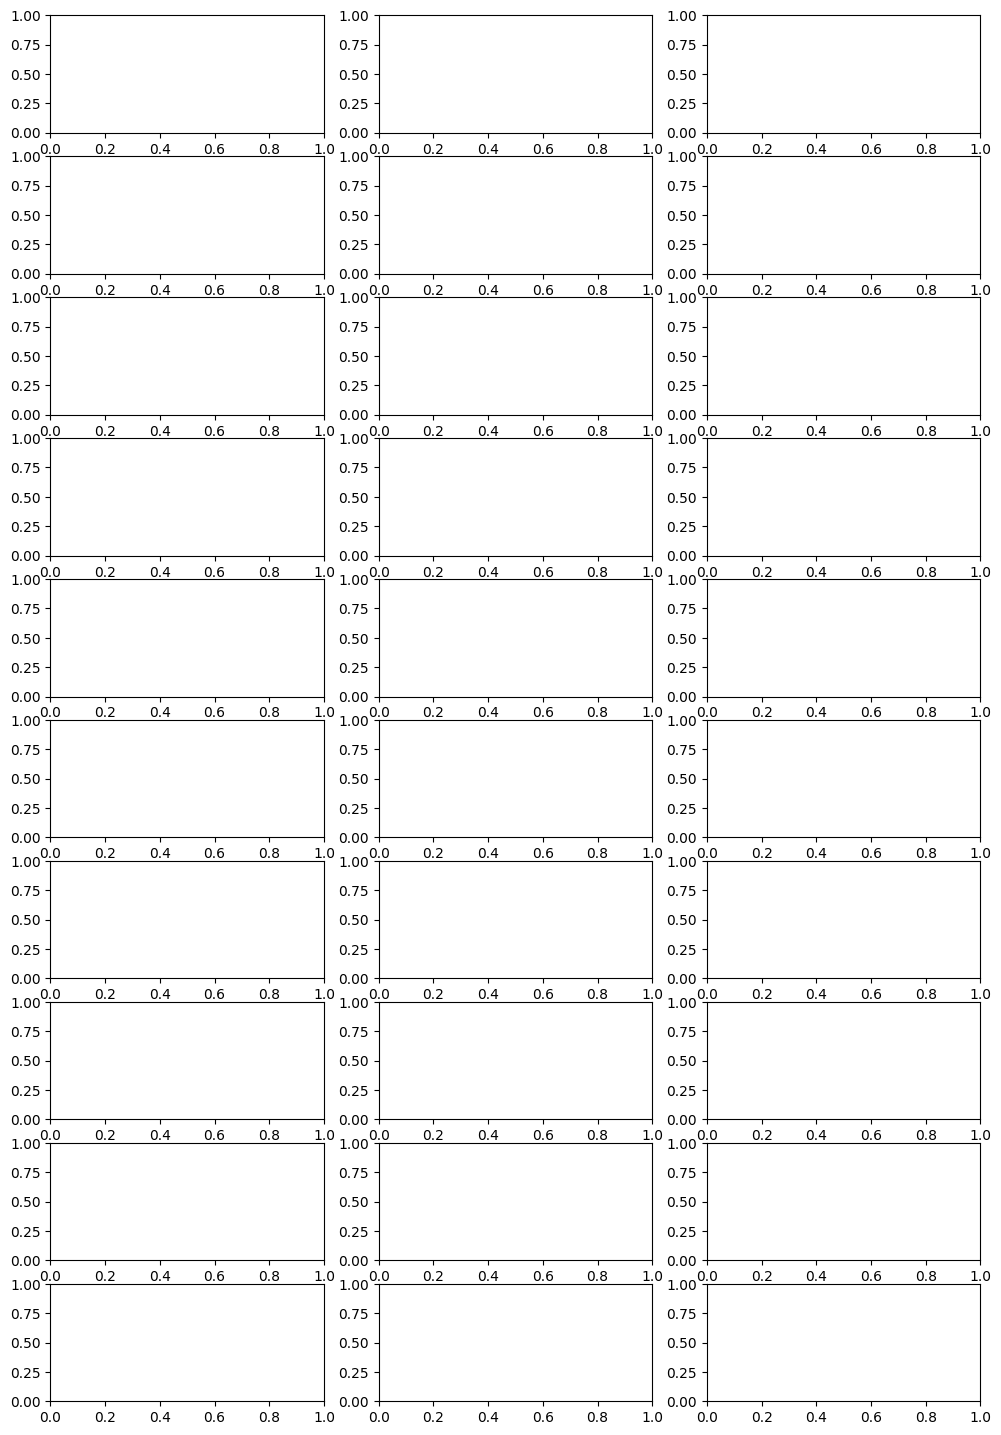

In [250]:
pos = [70, 4, 0, 31, 26, 14, 53, 33, 60, 61]

# Código para crear gráficos
fig, axs = plt.subplots(10, 3, figsize=(12, 18))
i = 0
for p in pos:
    digit = x[p]  # Asumiendo que x es la variable que contiene tus datos
    digit_pixels = digit.reshape(28, 28)
    digit_pixels = thresholdOtsu(digit_pixels)
    digit_pixels = digit_pixels.astype(np.uint8)
    
    axs[i, 0].imshow(digit_pixels, cmap='binary')
    
    rotated_image_np = np.rot90(digit_pixels, k=180 // 90)
    axs[i, 1].imshow(rotated_image_np, cmap='binary')
    
    axs[i, 2].imshow(escPeque(digit_pixels), cmap='binary')
    
    i += 1

plt.tight_layout()
plt.show()

'''# Crear una figura y un conjunto de subtramas con un diseño de 9 filas y 3 columnas
fig, axs = plt.subplots(9, 3, figsize=(12, 18))

# Puedes acceder a cada subtrama individual utilizando un índice de fila y columna
# Ejemplo de cómo trazar algo en una subtrama específica
axs[0, 0].plot([1, 2, 3, 4], [1, 4, 2, 3])

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()'''

In [362]:
file_name = "fourier.csv"

# Crear y escribir arrays en un ciclo
with open(file_name, "w") as file:
    for i in range(len(x)):
        digit = x[i]
        digit_pixels = digit.reshape(28, 28)
        digit_pixels = thresholdOtsu(digit_pixels)
        digit_pixels = digit_pixels.astype(np.uint8)
        arr = find_fourier_descriptorsRotation(digit_pixels)
        maxi = max(arr)
        diff = abs(maxi - min(arr))
        long = len(arr)
        prom = np.mean(arr)
        line = str(y[i])+ ","+ str(maxi)+ ","+ str(diff)+ ","+ str(long) + ","+ str(prom)+ "," + ",".join(map(str, arr)) + "\n"
        file.write(line)

d:\Repositorios\VisionArtificial\segmentacion\otsu.py:43: RuntimeWarning: invalid value encountered in scalar divide
  m_f = m/sum(f)


In [363]:
import pandas as pd
file_path = 'fourier.csv'
column_names = ['label', 'Maximo', 'Rango','longitud', 'Promedio'] 
df = pd.read_csv(file_path, usecols=range(5),header=None, names=column_names)

display(df)

,label,Maximo,Rango,longitud,Promedio
0,2,1.511648,1.510192,79,0.063286
1,1,1.185742,1.181527,38,0.053175
2,0,8.080804,8.070823,45,0.267147
3,4,3.711739,3.710619,72,0.190012
4,1,1.356035,1.353783,36,0.062384
...,...,...,...,...,...
995,2,2.219089,2.218340,77,0.088088
996,0,5.027849,5.021589,53,0.135597
997,8,91.340773,91.329579,56,3.172574
998,9,3.491310,3.489216,48,0.154493


In [383]:
from sklearn.model_selection import train_test_split

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.67, random_state=56)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)  # Puedes ajustar el valor de k

# Entrenar el modelo con los datos de entrenamiento
knn.fit(X_train, y_train)
# Predecir etiquetas en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluar el rendimiento del modelo (por ejemplo, utilizando la precisión)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Precisión del modelo: {accuracy}')
print(report)


Precisión del modelo: 0.46119402985074626
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        62
           1       0.88      0.96      0.92        84
           2       0.29      0.53      0.38        72
           3       0.28      0.37      0.32        71
           4       0.53      0.56      0.55        75
           5       0.34      0.22      0.27        54
           6       0.05      0.02      0.02        62
           7       0.31      0.27      0.29        63
           8       0.38      0.16      0.22        64
           9       0.42      0.59      0.49        63

    accuracy                           0.46       670
   macro avg       0.43      0.44      0.42       670
weighted avg       0.45      0.46      0.44       670



In [384]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid as NC
from sklearn.model_selection import train_test_split as data_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

classifiers = {
	# "NC"         : NC(),
	#"LDA"        : LDA(),
	# "QDA"        : QDA(),
	#"SVM_linear" : SVM(kernel="linear"),
	 "SVM_radial" : SVM(kernel="rbf")
}

def classification(data_file, rounds=100, remove_disperse=[]):
	df_copy = data_file.copy() 
	
	if remove_disperse:
		df_copy = df_copy.drop(remove_disperse, axis=1)
	
	X = df_copy.drop('label', axis=1)
	y = df_copy['label']
	
	ans = {key: {"score" : []} for key, value in classifiers.items()}
	
	print("Classifying...")
	
	for i in range(rounds):
		X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.2)
		
		for name, classifier in classifiers.items():
			scaler = StandardScaler()
			scaler.fit(X_train)
			X_train = scaler.transform(X_train)
			X_test = scaler.transform(X_test)
			
			classifier.fit(X_train, y_train)
			score = classifier.score(X_test, y_test)
			
			ans[name]["score"].append(score)
		
	print("Classification done!")
	
	return ans

ans = classification(df)

def sumary(ans, title="Summary"):
	size = 70
	separator = "-"
	
	print(separator*size)
	print("SUMARY: {}".format(title))
	print(separator*size)
	print("CLASSIF\t\tMEAN\tMEDIAN\tMINV\tMAXV\tSTD")
	print(separator*size)
	
	for n in ans:
		m = round(np.mean(ans[n]["score"])*100, 2)
		med = round(np.median(ans[n]["score"])*100, 2)
		minv = round(np.min(ans[n]["score"])*100, 2)
		maxv = round(np.max(ans[n]["score"])*100, 2)
		std = round(np.std(ans[n]["score"])*100, 2)
		
		print("{:<16}{}\t{}\t{}\t{}\t{}".format(n, m, med, minv, maxv, std))
	
	print(separator*size)
	print()

sumary(ans)

Classifying...
Classification done!
----------------------------------------------------------------------
SUMARY: Summary
----------------------------------------------------------------------
CLASSIF		MEAN	MEDIAN	MINV	MAXV	STD
----------------------------------------------------------------------
SVM_radial      47.9	47.5	38.5	59.0	3.87
----------------------------------------------------------------------



In [385]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid as NC
from sklearn.model_selection import train_test_split as data_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

classifiers = {
	# "NC"         : NC(),
	#"LDA"        : LDA(),
	# "QDA"        : QDA(),
	"SVM_linear" : SVM(kernel="linear"),
	#"SVM_radial" : SVM(kernel="rbf")
}

def classification(data_file, rounds=100, remove_disperse=[]):
	df_copy = data_file.copy() 
	
	if remove_disperse:
		df_copy = df_copy.drop(remove_disperse, axis=1)
	
	X = df_copy.drop('label', axis=1)
	y = df_copy['label']
	
	ans = {key: {"score" : []} for key, value in classifiers.items()}
	
	print("Classifying...")
	
	for i in range(rounds):
		X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.2)
		
		for name, classifier in classifiers.items():
			scaler = StandardScaler()
			scaler.fit(X_train)
			X_train = scaler.transform(X_train)
			X_test = scaler.transform(X_test)
			
			classifier.fit(X_train, y_train)
			score = classifier.score(X_test, y_test)
			
			ans[name]["score"].append(score)
		
	print("Classification done!")
	
	return ans

ans = classification(df)

def sumary(ans, title="Summary"):
	size = 70
	separator = "-"
	
	print(separator*size)
	print("SUMARY: {}".format(title))
	print(separator*size)
	print("CLASSIF\t\tMEAN\tMEDIAN\tMINV\tMAXV\tSTD")
	print(separator*size)
	
	for n in ans:
		m = round(np.mean(ans[n]["score"])*100, 2)
		med = round(np.median(ans[n]["score"])*100, 2)
		minv = round(np.min(ans[n]["score"])*100, 2)
		maxv = round(np.max(ans[n]["score"])*100, 2)
		std = round(np.std(ans[n]["score"])*100, 2)
		
		print("{:<16}{}\t{}\t{}\t{}\t{}".format(n, m, med, minv, maxv, std))
	
	print(separator*size)
	print()

sumary(ans)

Classifying...
Classification done!
----------------------------------------------------------------------
SUMARY: Summary
----------------------------------------------------------------------
CLASSIF		MEAN	MEDIAN	MINV	MAXV	STD
----------------------------------------------------------------------
SVM_linear      46.38	46.0	37.0	55.0	3.08
----------------------------------------------------------------------



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X = df.iloc[:, 1:]  # Selecciona todas las columnas excepto la primera
y = df.iloc[:, 0]   # Selecciona la primera columna como etiquetas

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializa el clasificador k-NN
knn = KNeighborsClassifier(n_neighbors=10)  # Puedes ajustar el valor de 'n_neighbors'

# Entrena el modelo con los datos de entrenamiento
knn.fit(X_train, y_train)

# Predice las etiquetas para el conjunto de pruebas
y_pred = knn.predict(X_test)

# Evalúa la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

Precisión del modelo: 0.60


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df.iloc[:, 1:] 

num_clusters = 10  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajusta el modelo a los datos
kmeans.fit(X)

# Predice los clústeres para los datos
y_pred = kmeans.predict(X)

# Calcula la puntuación de silueta para evaluar la calidad del modelo
silhouette_avg = silhouette_score(X, y_pred)
print(f"Puntuación de silueta: {silhouette_avg:.2f}")

c:\Users\Daphne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Puntuación de silueta: 0.54
